In [ ]:
import cv2
import json
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import normalize
from datetime import datetime
from os.path import join
from torch.utils.data import Dataset
from torch import nn
from torchvision import models
from sklearn.metrics import confusion_matrix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def iou(rect1, rect2):
    """
    Input: two rectangles
    Output: IOU value, which should be 0 if the rectangles do not overlap.
    """
    
    #get coords of overlap
    xL = max(rect1[0], rect2[0])
    yT = max(rect1[1], rect2[1])
    xR = min(rect1[2], rect2[2])
    yB = min(rect1[3], rect2[3])

    #return 0 for no overlap
    if xR < xL or yB < yT:
        return 0

    #area of overlap
    olap = area([xL,yT,xR,yB])

    #get area of both rectangles
    area1 = area(rect1)
    area2 = area(rect2)

    #calculate iou -- intersect / union
    iou = olap / (area1 + area2 - olap)

    return iou
    
def area(rect):
    """
    Input: list representing corner coordinates of a rectangle [x left, y top, x right, y bottom]
    Output: area of rectangle
    """
    h = rect[3] - rect[1]
    w = rect[2] - rect[0]
    return h * w

def predictions_to_detections(predictions, iou_threshold=0.5):
    """
    Input: List of region predictions

    Output: List of region predictsions that are considered to be
    detection results. These are ordered by activation with all class
    0 predictions eliminated, and the non-maximum suppression
    applied.
    """
    output = []
    #convert predictions to numpy array
    preds = []
    for p in predictions:
        preds.append(np.asarray(list(p.values())))
    preds = np.asarray(preds)
    #sort based on descending activation
    argOrder = preds[:,1].argsort()[::-1]
    preds = preds[argOrder]

    #remove entries with class = 0
    mask = np.where(preds[:,0] != 0)[0]
    argOrder = argOrder[mask]
    preds = preds[mask]
    
    validBoxes = []
    #remove bounding boxes with large overlap on largest activation bounding box
    while argOrder.shape[0] != 0:
        iouVal = []
        validBoxes.append(argOrder[0])
        ind = np.where(preds[1:,0] == preds[0][0])[0]
        if preds[preds[:,0] == preds[0][0]].shape[0] == 0:
          break
        #calculate iou val between first bounding box and every other bounding box with the same class
        #maps iou to every other bounding box, and uses np.tile to repeat initial bounding box the correct number of times
        iouVal = np.asarray( list( map(iou, preds[1:,2][preds[1:,0] == preds[0][0]], np.tile(preds[0][2], (preds[preds[:,0] == preds[0][0]].shape[0]-1,1)) ) ) )

        #delete boxes with an iouVal over the threshold
        argOrder = np.delete(argOrder, np.concatenate(([0],ind[iouVal > iou_threshold]+1)), axis=0)
        preds = np.delete(preds, np.concatenate(([0],ind[iouVal > iou_threshold]+1)), axis=0)
    
    if len(validBoxes) == 0:
      out = []
    else:
      out = list(np.asarray(predictions)[np.asarray(validBoxes)])
    return out

def evaluate(detections, gt_detections, n=10):
    """
    Input:
    1. The detections returned by the predictions_to_detections function
    2. The list of ground truth regions, and
    3. The maximum number (n) of detections to consider.

    The calculation must compare each detection regiong the ground
    truth detection regions to determine which are correct and which
    are incorrect.  Finally, it must compute the average precision for
    up to n detections.

    Returns:
    list of correct detections,
    list of incorrect detections,
    list of ground truth regions that are missed,
    AP@n value.
    """

    #convert to numpy array
    detect = []
    gt = []
    for d in detections:
        detect.append(np.asarray(list(d.values())))
    for g in gt_detections:
        gt.append(np.asarray(list(g.values())))
    detect = np.asarray(detect)
    gt = np.asarray(gt)
    numCorrect = gt.shape[0]
    countN = 0

    #binary array, correct and incorrect lists for detections
    b = []
    correct = []
    incorrect = []

    #detections already ordered from predictions_to_detections()
    for d in detect:

        if gt.shape[0] == 0:
            break

        #only check ground truths with the same class
        gtSame = gt[np.where(gt[:,0] == d[0])]
        index = np.where(gt[:,0] == d[0])[0]
        if gtSame.shape[0] == 0:
            incorrect.append(countN)
            b.append(0)
            countN += 1
            continue

        #get iouValues and sort in descending order
        iouVal = np.asarray( list( map(iou, gtSame[:,1], np.tile(d[2], (gtSame.shape[0],1)) ) ) )
        iouSort = iouVal.argsort()[::-1]
        g = gtSame[iouSort[0]]

        #remove if there is enough overlap and mark as correct others incorrect
        if iouVal[iouSort[0]] > 0.5:
            b.append(1)
            correct.append(countN)
            gt = np.delete(gt, index[iouSort[0]],axis=0)
        else:
            incorrect.append(countN)
            b.append(0)
        countN += 1
    #get ap value
    b = np.asarray(b)
    if b.shape[0] < 10:
        z = np.zeros(10)
        z[:b.shape[0]] = b
        b = z
    else:
        b = b[:10]
    ap = np.convolve(b, np.ones(b.shape[0]), mode='full')[:b.shape[0]]/np.arange(1,b.shape[0]+1)
    ap = (1/numCorrect)*np.sum(b*ap)
    
    #format outputs
    if len(correct) == 0:
        cor = []
    else:
        cor = list(np.asarray(detections)[np.asarray(correct)])
    if len(incorrect) == 0:
        incor = []
    else:
        incor = list(np.asarray(detections)[np.asarray(incorrect)])
    return cor, incor, gt, ap

In [ ]:
class RCNN(nn.Module):
    def __init__(self, C):
        super(RCNN, self).__init__()
        self.C = C
        # Pretrained backbone.
        resnet = models.resnet50(pretrained=True)

        # Remove the last two layers of the pretrained network.
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze backbone weights. 
        for param in self.backbone.parameters():
            param.requires_grad = False

        #classifier layer
        self.fc = nn.Linear(7*7*2048, C+1)
        #regression layer
        self.reg = nn.Linear(7*7*2048, 4*C)

    def forward(self, x, batch):
        # returns a (batch_size x num_classes) tensor for classification
        # and a (batch_size x num_classes x 4) tensor for the bounding box regression. 
        x_backbone = self.backbone(x)

        #flatten for fully connected layers
        inpt = torch.flatten(x_backbone, start_dim=1)
        out1 = self.fc(inpt)
        out2 = self.reg(inpt)

        return out1, out2.view(batch,self.C,4)

In [ ]:
class Dataset(Dataset):
    '''
    Dataset for Train and Validation.
    Input:
        data_root - path to either the train or valid image directories
        json_file - path to either train.json or valid.json
        candidate_image_size
    Output:
        candidate_image - 3 x M x M tensor
        candidate_region - 1 x 4 tensor
        ground_truth_region - 1 x 4 tensor
        ground_truth_class
    '''
    def __init__(self, data_root, json_file, candidate_image_size):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root

        self.images = []
        self.candidate_regions = torch.empty((0, 4), dtype=int)
        self.ground_truth_regions = torch.empty((0, 4), dtype=int)
        self.ground_truth_classes = torch.empty(0, dtype=int)
        for key, values in data_dict.items():
            for val in values:
                self.images.append(key)
                self.candidate_regions = torch.cat((self.candidate_regions, torch.tensor(val['bbox']).unsqueeze(0)), dim=0)
                self.ground_truth_regions = torch.cat((self.ground_truth_regions, torch.tensor(val['correct_bbox']).unsqueeze(0)), dim=0)
                self.ground_truth_classes = torch.cat((self.ground_truth_classes, torch.tensor(val['class']).unsqueeze(0)))

        self.candidate_image_size = candidate_image_size

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        # Transform to convert to tensor, resize, and normalize.
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=mean, std=std)])

        self.cached_image = None
        self.cached_image_path = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        if self.cached_image_path != image_path:
            image = cv2.imread(image_path)
            self.cached_image_path = image_path
            self.cached_image = image
        else:
            image = self.cached_image

        # Crop the image to the candidate region.
        candidate_region = self.candidate_regions[idx, :]
        candidate_image = image[candidate_region[1]:candidate_region[3], candidate_region[0]:candidate_region[2], :]

        # Resize candidate image.
        candidate_image = cv2.resize(candidate_image, (self.candidate_image_size, self.candidate_image_size))

        # Apply transform to resize and normalize the candidate image.
        candidate_image = self.transform(candidate_image)

        return candidate_image, candidate_region, self.ground_truth_regions[idx, :], self.ground_truth_classes[idx]


class DatasetTest(Dataset):
    """
    Dataset for Test.
    Input:
        data_root - path to the test image directory
        json_file - path to test.json
        candidate_image_size
    Returns:
        image - numpy array (BGR)
        candidate_images - NUM_CANDIDATE_REGIONS x 3 x M x M tensor
        candidate_regions - all candidate regions for an image 
        ground_truth_regions - all ground truth regions for an image
        ground_truth_classes - all ground truth classes for an image
    """
    def __init__(self, data_root, json_file, candidate_image_size):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root

        self.images = []
        self.candidate_regions = []
        self.ground_truth_regions = []
        self.ground_truth_classes = []
        for key, values in data_dict.items():
            self.images.append(key)

            regions = torch.empty((len(values['candidate_regions']), 4), dtype=int)
            for i, region in enumerate(values['candidate_regions']):
                regions[i, :] = torch.tensor(region)
            self.candidate_regions.append(regions)

            labels = torch.empty((len(values['ground_truth_regions'])), dtype=int)
            regions = torch.empty((len(values['ground_truth_regions']), 4), dtype=int)
            for i, region in enumerate(values['ground_truth_regions']):
                regions[i, :] = torch.tensor(region['bbox'])
                labels[i] = region['class']
            self.ground_truth_regions.append(regions)
            self.ground_truth_classes.append(labels)

        self.candidate_image_size = candidate_image_size

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        # Transform to convert to tensor, resize, and normalize.
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=mean, std=std)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        image = cv2.imread(image_path)

        # Apply transform to resize and normalize the candidate images.
        idx_candidate_regions = self.candidate_regions[idx]
        candidate_images = torch.empty((len(idx_candidate_regions), 3, self.candidate_image_size, self.candidate_image_size))
        for i, region in enumerate(idx_candidate_regions):
            candidate_image = image[region[1]:region[3], region[0]:region[2], :]
            candidate_image = cv2.resize(candidate_image, (self.candidate_image_size, self.candidate_image_size))
            candidate_image = self.transform(candidate_image)
            candidate_images[i] = candidate_image
        return image, candidate_images, self.candidate_regions[idx], self.ground_truth_regions[idx], self.ground_truth_classes[idx]

In [ ]:
def mini_batch_gd(model, criterion, criterion2, optimizer, train_loader, test_loader, epochs,device):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    bestLoss = np.inf
    endEarly = 0

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        b_losses = []
        count = 0
        for cand_img, c_reg, gt_reg, gt_c in train_loader:
          inputs = cand_img
          #scale ground truths
          gt_reg = gt_reg.float()
          gt_reg[:,0] = (gt_reg[:,0]- c_reg[:,0]).float()/(c_reg[:,2] - c_reg[:,0]).float()
          gt_reg[:,2] = (gt_reg[:,2]- c_reg[:,0]).float()/(c_reg[:,2] - c_reg[:,0]).float()
          gt_reg[:,1] = (gt_reg[:,1]- c_reg[:,1]).float()/(c_reg[:,3] - c_reg[:,1]).float()
          gt_reg[:,3] = (gt_reg[:,3]- c_reg[:,1]).float()/(c_reg[:,3] - c_reg[:,1]).float()
          targets = torch.cat((torch.reshape(gt_c, (gt_c.shape[0],1)), gt_reg), 1)
          
          # move data to device
          inputs, targets = inputs.to(device), targets.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs, gt_c.shape[0])
          
          #get box outputs at the correct class, if class = 0 pick index 0 from outputs
          targetTmp = targets[:,0].long().cpu().numpy()
          targetTmp = np.where(targetTmp == 0, 1, targetTmp)-1
          outTmp = outputs[1][torch.arange(outputs[1].size(0)),targetTmp]

          #classifier loss
          lossC = criterion(outputs[0], targets[:,0].long())
          
          #get regression output values at the correct classes
          targetTmp = targets[:,0][targets[:,0].long() != 0].long()-1 
          outputTmp = outputs[1][targets[:,0].long()!=0] 
          loss_reg = outputTmp[torch.arange(outputTmp.size(0)),targetTmp]

          #regression mse loss
          lossB = criterion2(loss_reg, targets[:,1:][targets[:,0].long() != 0].float())
          lossB = lossB/targets.shape[0]

          #combine loss
          loss = lossC + 2*lossB
          loss = loss.float()

          # Backward and optimize
          loss.backward()
          optimizer.step()

          train_loss.append(loss.item())
          b_losses.append(lossB.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss)

        print("train", train_loss)
        print("regression loss", np.mean(b_losses))

        test_loss = []
        for cand_img, c_reg, gt_reg, gt_c in test_loader:
          inputs = cand_img
          #scale ground truths
          gt_reg = gt_reg.float()
          gt_reg[:,0] = (gt_reg[:,0]- c_reg[:,0]).float()/(c_reg[:,2] - c_reg[:,0]).float()
          gt_reg[:,2] = (gt_reg[:,2]- c_reg[:,0]).float()/(c_reg[:,2] - c_reg[:,0]).float()
          gt_reg[:,1] = (gt_reg[:,1]- c_reg[:,1]).float()/(c_reg[:,3] - c_reg[:,1]).float()
          gt_reg[:,3] = (gt_reg[:,3]- c_reg[:,1]).float()/(c_reg[:,3] - c_reg[:,1]).float()
          targets = torch.cat((torch.reshape(gt_c, (gt_c.shape[0],1)), gt_reg), 1)
          
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs, gt_c.shape[0])
          
          #classifier loss
          lossC = criterion(outputs[0], targets[:,0].long())

          #get regression output values at the correct classes
          targetTmp = targets[:,0][targets[:,0].long() != 0].long()-1
          outputTmp = outputs[1][targets[:,0].long()!=0]
          loss_reg = outputTmp[torch.arange(outputTmp.size(0)),targetTmp]

          #regression mse loss
          lossB = criterion2(loss_reg, targets[:,1:][targets[:,0].long() != 0].float())
          lossB = lossB/targets.shape[0]

          #combined loss
          loss = lossC + 2*lossB
          loss = loss.float()
          
          test_loss.append(loss.item())

        test_loss = np.mean(test_loss)
        print("test", test_loss)
        if test_loss < bestLoss:
            bestLoss = test_loss
            endEarly = 0
        else:
            endEarly += 1
        
        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        if endEarly == 10:
            print(f'End Early: Epoch {it+1}/{epochs},Train Loss: {train_loss:.4f}, \
                Test Loss: {test_loss:.4f}, Duration: {dt}')
            break
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
            Test Loss: {test_loss:.4f}, Duration: {dt}')
  
    return train_losses, test_losses

In [ ]:
#load data
path = '.'
data_train = Dataset(path + '/data_small/data/train', path + '/data_small/train.json', candidate_image_size=224)
data_valid = Dataset(path + '/data_small/data/valid', path + '/data_small/valid.json', candidate_image_size=224)
data_test = DatasetTest(path + '/data_small/data/test', path + '/data_small/test.json', candidate_image_size=224)

In [ ]:
#Number of classes
K = 4

batch_size = 128

#load model and necessary optimizers/loss functions
model = RCNN(K)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss(reduction='sum')

#data loaders
train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=data_valid, batch_size=batch_size, shuffle=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#training
train_losses, test_losses = mini_batch_gd(model, criterion, criterion2, optimizer, train_loader, valid_loader, 100,device)

train 277.3953473409017
regression loss 138.68499781290691
test 66.49712996049361
Epoch 1/100, Train Loss: 277.3953,             Test Loss: 66.4971, Duration: 0:01:30.455520
train 355.7908528645833
regression loss 177.84935423533122
test 246.42444957386363
Epoch 2/100, Train Loss: 355.7909,             Test Loss: 246.4244, Duration: 0:01:29.710330
train 431.56031061808267
regression loss 215.70969378153484
test 189.73453644188967
Epoch 3/100, Train Loss: 431.5603,             Test Loss: 189.7345, Duration: 0:01:28.960645
train 539.4935770670573
regression loss 269.70105209350584
test 261.96010520241475
Epoch 4/100, Train Loss: 539.4936,             Test Loss: 261.9601, Duration: 0:01:29.261791
train 351.83947423299156
regression loss 175.90021158854168
test 266.7868472012606
Epoch 5/100, Train Loss: 351.8395,             Test Loss: 266.7868, Duration: 0:01:29.061050
train 239.54736913045247
regression loss 119.73827298482259
test 139.0649178244851
Epoch 6/100, Train Loss: 239.5474,    

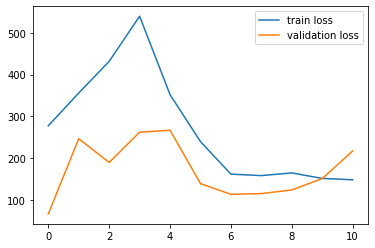

In [ ]:
#train and validation loss plot
plt.plot(train_losses[:11], label='train loss')
plt.plot(test_losses[:11], label='validation loss')
plt.legend()
plt.show()

In [ ]:
##### TEST TRAINING DATA #####
n_correct = 0.
n_total = 0.

y_test = np.array([])
y_test2 = np.array([])
pred_test = np.array([])
pred_test2 = np.array([])

for cand_img, c_reg, gt_reg, gt_c in train_loader:
  #store ground truths
  if pred_test2.shape[0] == 0:
     y_test2 = gt_reg.cpu().numpy()
  else:
     y_test2 = np.concatenate((y_test2, gt_reg.cpu().numpy()))

  inputs = cand_img

  gt_reg = gt_reg.float()
  gt_reg[:,0] = (gt_reg[:,0]- c_reg[:,0]).float()/(c_reg[:,2] - c_reg[:,0]).float()
  gt_reg[:,2] = (gt_reg[:,2]- c_reg[:,0]).float()/(c_reg[:,2] - c_reg[:,0]).float()
  gt_reg[:,1] = (gt_reg[:,1]- c_reg[:,1]).float()/(c_reg[:,3] - c_reg[:,1]).float()
  gt_reg[:,3] = (gt_reg[:,3]- c_reg[:,1]).float()/(c_reg[:,3] - c_reg[:,1]).float()
  targets = torch.cat((torch.reshape(gt_c, (gt_c.shape[0],1)), gt_reg), 1)
  
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs, gt_c.shape[0])

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs[0], 1)
  
  pred_test = np.concatenate((pred_test, predictions.cpu().numpy()))
  y_test = np.concatenate((y_test, targets[:,0].cpu().numpy()))

  #map boxes back to image
  targetTmp = targets[:,0].cpu().numpy()
  targetTmp = np.where(targetTmp == 0, 1, targetTmp)-1
  outTmp = outputs[1][torch.arange(outputs[1].size(0)),targetTmp]
  outTmp = outTmp.cpu().detach()
  outTmp[:,0] = (outTmp[:,0]*(c_reg[:,2] - c_reg[:,0])) + c_reg[:,0]
  outTmp[:,2] = (outTmp[:,2]*(c_reg[:,2] - c_reg[:,0])) + c_reg[:,0]
  outTmp[:,1] = (outTmp[:,1]*(c_reg[:,3] - c_reg[:,1])) + c_reg[:,1]
  outTmp[:,3] = (outTmp[:,3]*(c_reg[:,3] - c_reg[:,1])) + c_reg[:,1]
  
  #store mapped boxes
  if pred_test2.shape[0] == 0:
     pred_test2 = outTmp
  else:
     pred_test2 = np.concatenate((pred_test2, outTmp))
  # update counts
  n_correct += (predictions == targets[:,0]).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total
print("Training Accuracy: ", train_acc)
cm = confusion_matrix(pred_test, y_test)
print("Confusion Matrix: ")
print(cm)

#calculate average iou for training data
t = np.where(y_test == pred_test)[0]
iouLis = []
for val in t:
    if y_test[val] != 0:
        #print(pred_test2[val])
        #print(y_test2[val])
        iouLis.append(iou(pred_test2[val],y_test2[val]))
print("Average IOU: ", sum(iouLis)/len(iouLis))

Training Accuracy:  0.998162006039123
Confusion Matrix: 
[[5292    0    0    0    0]
 [   7  621    0    0    0]
 [   1    0  542    0    0]
 [   5    0    0  747    0]
 [   1    0    0    0  401]]
Average IOU:  0.004774763273942212


In [ ]:
##### TEST VALIDATION DATA #####
n_correctV = 0.
n_totalV = 0.

y_testV = np.array([])
y_test2V = np.array([])
pred_testV = np.array([])
pred_test2V = np.array([])

for cand_img, c_reg, gt_reg, gt_c in valid_loader:
  #store ground truths
  if pred_test2V.shape[0] == 0:
     y_test2V = gt_reg.cpu().numpy()
  else:
     y_test2V = np.concatenate((y_test2V, gt_reg.cpu().numpy()))
  inputs = cand_img
  gt_reg = gt_reg.float()
  gt_reg[:,0] = (gt_reg[:,0]- c_reg[:,0]).float()/(c_reg[:,2] - c_reg[:,0]).float()
  gt_reg[:,2] = (gt_reg[:,2]- c_reg[:,0]).float()/(c_reg[:,2] - c_reg[:,0]).float()
  gt_reg[:,1] = (gt_reg[:,1]- c_reg[:,1]).float()/(c_reg[:,3] - c_reg[:,1]).float()
  gt_reg[:,3] = (gt_reg[:,3]- c_reg[:,1]).float()/(c_reg[:,3] - c_reg[:,1]).float()
  targets = torch.cat((torch.reshape(gt_c, (gt_c.shape[0],1)), gt_reg), 1)

  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs, gt_c.shape[0])

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs[0], 1)
  
  pred_testV = np.concatenate((pred_testV, predictions.cpu().numpy()))
  y_testV = np.concatenate((y_testV, targets[:,0].cpu().numpy()))

  #map boxes back to image
  targetTmp = targets[:,0].cpu().numpy()
  targetTmp = np.where(targetTmp == 0, 1, targetTmp)-1
  outTmp = outputs[1][torch.arange(outputs[1].size(0)),targetTmp]
  outTmp = outTmp.cpu().detach()
  outTmp[:,0] = (outTmp[:,0]*(c_reg[:,2] - c_reg[:,0])) + c_reg[:,0]
  outTmp[:,2] = (outTmp[:,2]*(c_reg[:,2] - c_reg[:,0])) + c_reg[:,0]
  outTmp[:,1] = (outTmp[:,1]*(c_reg[:,3] - c_reg[:,1])) + c_reg[:,1]
  outTmp[:,3] = (outTmp[:,3]*(c_reg[:,3] - c_reg[:,1])) + c_reg[:,1]
  
  #store mapped boxes
  if pred_test2V.shape[0] == 0:
     pred_test2V = outTmp
  else:
     pred_test2V = np.concatenate((pred_test2V, outTmp))
  # update counts
  n_correctV += (predictions == targets[:,0]).sum().item()
  n_totalV += targets.shape[0]

train_accV = n_correctV / n_totalV
print("Validation Accuracy: ", train_accV)
cmV = confusion_matrix(pred_testV, y_testV)
print("Confusion Matrix:", cmV)

#calculate average iou for validation data
tV = np.where(y_testV == pred_testV)[0]
iouLisV = []
for val in tV:
    if y_testV[val] != 0:
        #print(pred_test2[val])
        #print(y_test2[val])
        iouLisV.append(iou(pred_test2V[val],y_test2V[val]))
print("Average IOU:", sum(iouLisV)/len(iouLisV))

Validation Accuracy:  0.8933021806853583
Confusion Matrix: [[833   9  22  18  12]
 [ 18 108   0   1   2]
 [ 20   0  80   0   0]
 [ 11   0   0  78   3]
 [ 14   7   0   0  48]]
Average IOU: 0.0038113412078958093


im 1.0 ap 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


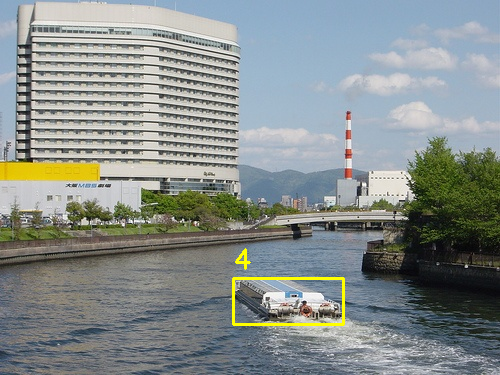

im 2.0 ap 0.0


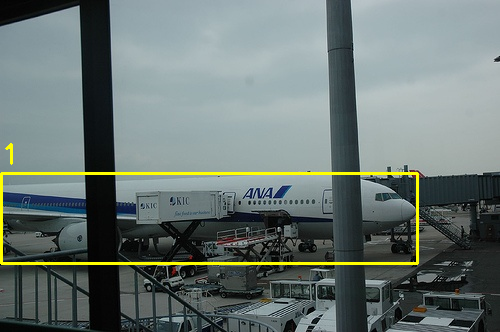

im 3.0 ap 0.0


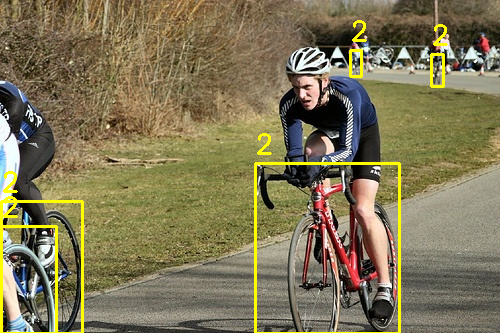

im 4.0 ap 0.0
1
1
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


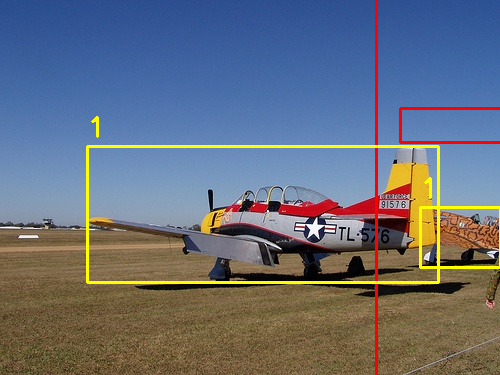

im 5.0 ap 0.0
4
4


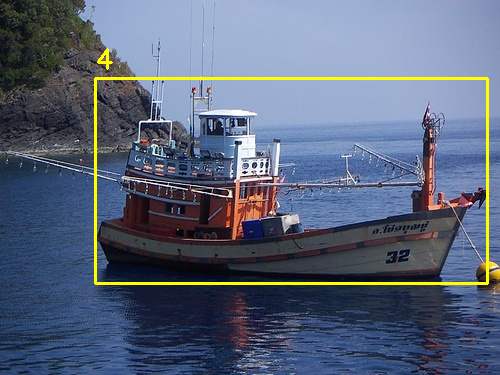

im 6.0 ap 0.0
1
1
1


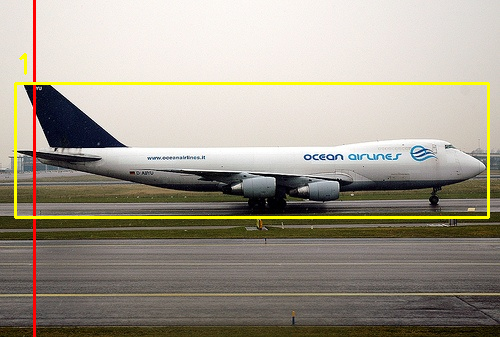

im 7.0 ap 0.0
1
1
1


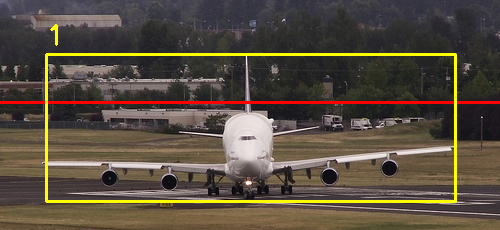

im 8.0 ap 0.0
1
1


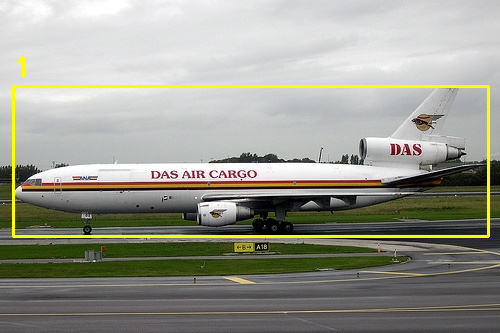

im 9.0 ap 0.0


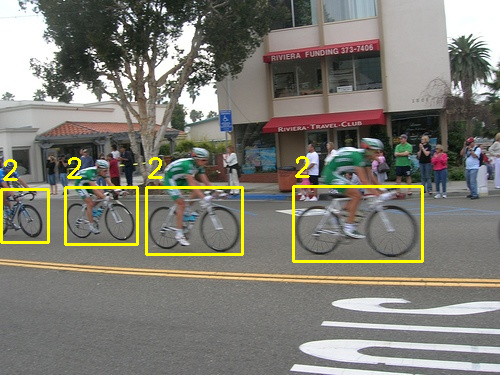

im 10.0 ap 0.0
3


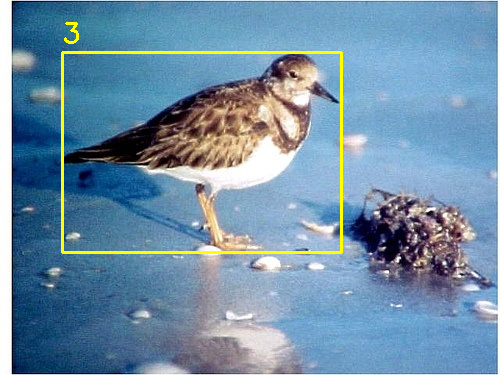

In [ ]:
##### Test the Test Data #####

#store ap, correct, incorrect, and uncovered ground truths
apLis = []
corLis = []
incorLis =[]
gtRemLis = []

n = 0.
for im, cand_img, c_reg, gt_reg, gt_c in data_test:
  n+=1
  inputs = cand_img
  
  # move data to GPU
  inputs = inputs.to(device)
  
  # Forward pass
  outputs = model(inputs,inputs.shape[0])

  # Get activation values and prediction
  # torch.max returns both max and argmax
  activations = F.softmax(outputs[0],dim=1)
  actMax, predictions = torch.max(activations, 1)
  
  #map outputs to original image coordinates
  targetTmp = predictions.cpu().numpy()
  targetTmp = np.where(targetTmp == 0, 1, targetTmp)-1
  outTmp = outputs[1][torch.arange(outputs[1].size(0)),targetTmp]
  outTmp = outTmp.cpu().detach()
  outTmp[:,0] = (outTmp[:,0]*(c_reg[:,2] - c_reg[:,0])) + c_reg[:,0]
  outTmp[:,2] = (outTmp[:,2]*(c_reg[:,2] - c_reg[:,0])) + c_reg[:,0]
  outTmp[:,1] = (outTmp[:,1]*(c_reg[:,3] - c_reg[:,1])) + c_reg[:,1]
  outTmp[:,3] = (outTmp[:,3]*(c_reg[:,3] - c_reg[:,1])) + c_reg[:,1]
  outTmp = outTmp.numpy()
  
  activations = activations.cpu().detach().numpy()

  #form prediction and ground truth dictionaries
  predDict = []
  for i in range(outTmp.shape[0]):
    predDict.append({"class":int(predictions[i].cpu()), "a":float(actMax[i].cpu()), "rectangle":outTmp[i]})
  gtDict = []
  for i in range(gt_reg.shape[0]):
    gtDict.append({"class":int(gt_c[i]),"rectangle":gt_reg[i].numpy()})
  
  #perform testing
  predOut = predictions_to_detections(predDict)
  cor,incor,gtRem, ap = evaluate(predOut, gtDict)

  apLis.append(ap)

  #format outputs into arrays
  if len(cor) != 0:
    for val in cor:
      corLis.append(list(val.values()))
  if len(incor) != 0:
    for val in incor:
      incorLis.append(list(val.values()))
  if len(gtRem) != 0:
    for val in gtRem:
      gtRemLis.append(val)
  
  #show images and boxes for first 10 images
  if n < 11:
    #print ap value for image
    print("im", n, "ap", ap)
    
    for val in cor:
      rect = val["rectangle"]
      cv2.rectangle(im, tuple(rect[:2]), tuple(rect[2:]), (0,255,0), 2)
      cv2.putText(im, str(val["class"]), (rect[0],rect[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
    for val in incor:
      rect = val["rectangle"]
      cv2.rectangle(im, tuple(rect[:2]), tuple(rect[2:]), (0,0,255), 2)
      cv2.putText(im, str(val["class"]), (int(rect[0]),int(rect[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
      print(val["class"])
    for val in gtRem:
      #print(val)
      rect = val[1]
      cv2.rectangle(im, tuple(rect[:2]), tuple(rect[2:]), (0,255,255), 2)
      cv2.putText(im, str(val[0]), (rect[0],rect[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,255), 2)
    cv2_imshow(im)